## Plotting AlphaFold output

### 1. Importing dependencies

In [1]:
import os
import glob
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 2. Sorting through output folder files
The folder should contain something like this:

|&#128193; | | | |
|---------------------|--------------------|----------------------|---------------------|
|features.pkl         |ranked_1.pdb        |ranked_4.pdb          |relaxed_model_2.pdb  |
|relaxed_model_5.pdb  |result_model_3.pkl  |timings.json          |unrelaxed_model_3.pdb|
|msas                 |ranked_2.pdb        |ranking_debug.json    |relaxed_model_3.pdb  |
|result_model_1.pkl   |result_model_4.pkl  |unrelaxed_model_1.pdb |unrelaxed_model_4.pdb|
|ranked_0.pdb         |ranked_3.pdb        |relaxed_model_1.pdb   |relaxed_model_4.pdb  |
|result_model_2.pkl   |result_model_5.pkl  |unrelaxed_model_2.pdb |unrelaxed_model_5.pdb|
...

In [2]:
class ARG:
    def __init__(self, repo):
        self.input_dir = repo
        self.output_dir = repo
        self.name = name 

repo = [input('Please copy the path to your output folder (e.g. /Users/yourname/Documents/AFoutput ): ')] # This is a list of all output repositories
name = input('Please enter the name of your protein: ')

for r in repo:
    args = ARG(r)
    with open(os.path.join(r, "ranking_debug.json"), 'r') as f:
        ranking_dict = json.load(f)
        
    feature_dict = pickle.load(open(f'{args.input_dir}/features.pkl','rb'))
    is_multimer = ('result_model_1_multimer_v3_pred_0.pkl' in [os.path.basename(f) for f in os.listdir(path=args.input_dir)])
    if is_multimer==False:
        model_dicts = [pickle.load(open(f'{args.input_dir}/result_model_{f}{"_multimer_v3" if is_multimer else ""}{"_ptm" if is_multimer==False else ""}_pred_0.pkl','rb'))
                        for f in range(1,6)]
    else:
        model_dicts = [pickle.load(open(f'{args.input_dir}/result_model_{f}{"_multimer_v3" if is_multimer else ""}{"_ptm" if is_multimer==False else ""}_pred_{g}.pkl','rb')) 
                    for f in range(1,6) for g in range(5)]

### 3. Defining plot functions

In [3]:
def get_pae_plddt(model_dicts):
    out = {}
    for i,d in enumerate(model_dicts):
        out[f'model_{i+1}'] = {'plddt': d['plddt'], 
                               'pae':d['predicted_aligned_error']}
    return out
 
def generate_output_images(feature_dict, model_dicts, ranking_dict, 
                           out_dir, name, pae_plddt_per_model):
    msa = feature_dict['msa']
    seqid = (np.array(msa[0] == msa).mean(-1))
    seqid_sort = seqid.argsort()
    non_gaps = (msa != 21).astype(float)
    non_gaps[non_gaps == 0] = np.nan
    final = non_gaps[seqid_sort] * seqid[seqid_sort, None]
    #print(final)
    ###################### PLOT MSA WITH COVERAGE ####################
    
    plt.figure(figsize=(14, 4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.title(f"Sequence coverage ({name})")
    plt.imshow(final,
               interpolation='nearest', aspect='auto',
               cmap="rainbow_r", vmin=0, vmax=1, origin='lower')
    plt.plot((msa != 21).sum(0), color='black')
    plt.xlim(-0.5, msa.shape[1]-0.5)
    plt.ylim(-0.5, msa.shape[0]-0.5)
    plt.colorbar(label="Sequence identity to query")
    plt.xlabel("Positions")
    plt.ylabel("Sequences")
    
    ###################### PLOT LDDT PER POSITION ####################
    plt.subplot(1, 2, 2)
    plt.title(f"Predicted LDDT per position ({name})")
    
    colors = plt.cm.jet(np.linspace(0,1,len(pae_plddt_per_model)))
    s = 0
    for model_name, value in pae_plddt_per_model.items():
        pltlabel = model_name.replace('model_','')
        plt.plot(value["plddt"], 
                 label=f"{pltlabel}",
                 color=colors[s]) #, plddts: {round(list(ranking_dict['plddts'].values())[s], 6)}")
        s += 1
    ax = plt.gca()
    plt.legend(bbox_to_anchor=(1.05, 1.05), bbox_transform=ax.transAxes, title="Model:", fontsize=6)
    plt.ylim(0, 100)
    plt.xlim(-0.25, msa.shape[1]-0.75)
    plt.ylabel("Predicted LDDT")
    plt.xlabel("Positions")
    plt.savefig(f"{out_dir}/{name+('_' if name else '')}coverage_LDDT.pdf")
 
    ################# PLOT THE PREDICTED ALIGNED ERROR################
    num_models = len(model_dicts)
    plt.figure(figsize=(3 * num_models, 2), dpi=100)
    for n, (model_name, value) in enumerate(pae_plddt_per_model.items()):
        plt.subplot(1, num_models, n + 1)
        plt.title(model_name)
        plt.imshow(value["pae"], label=model_name, cmap="bwr", vmin=0, vmax=30)
        plt.colorbar()
    plt.savefig(f"{out_dir}/{name+('_' if name else '')}PAE.pdf")

### 4. Generating the plots

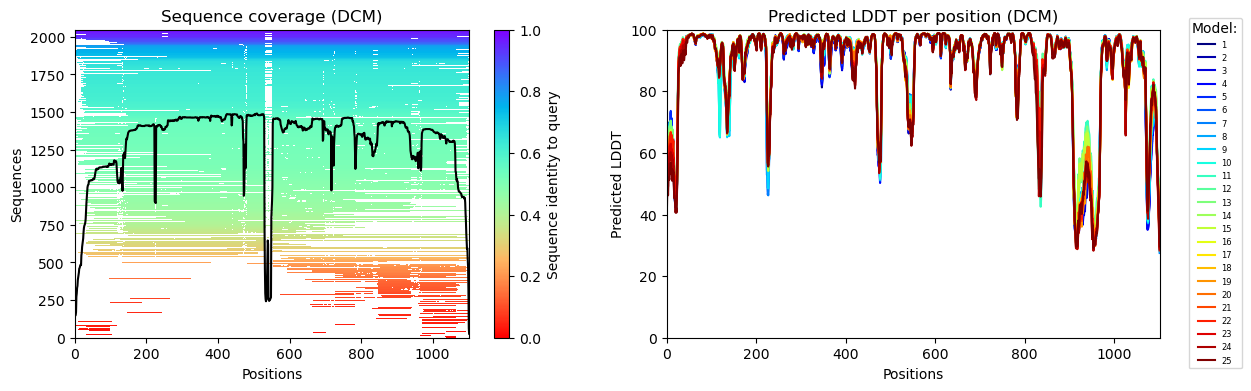

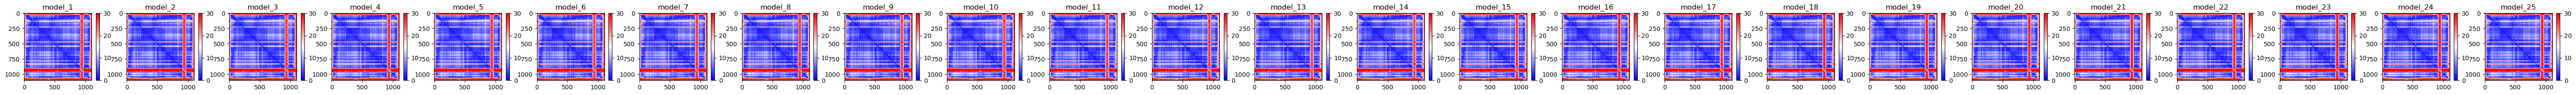

In [4]:
pae_plddt_per_model = get_pae_plddt(model_dicts)
generate_output_images(feature_dict, model_dicts, ranking_dict, 
                       args.output_dir if args.output_dir else args.input_dir, 
                       args.name, pae_plddt_per_model)

### 5. Saving PAE and pLDDT scores as .csv 
This is an *optional* step, allowing you to save the PAE and pLDDT scores in a smaller file format. If you have limited storage space, this will allow you to delete the large .pkl files and re-plot prediction metrics later.

In [69]:
plddts=[]
pae=[]
for key in pae_plddt_per_model.keys():
    plddts.append(pae_plddt_per_model[key]['plddt'])
    pae.append(pae_plddt_per_model[key]['pae'])

df_plddts = pd.DataFrame(plddts) 
df_plddts.to_csv(os.path.join(args.output_dir if args.output_dir else args.input_dir,r'plddt.csv'))
#df_pae = pd.DataFrame(pae) # 3-dimensional shape
#df_pae.to_csv(os.path.join(args.output_dir if args.output_dir else args.input_dir,r'pae.csv'))
#df = pd.DataFrame(pae_plddt_per_model)
#df.to_csv(os.path.join(args.output_dir if args.output_dir else args.input_dir,r'pae_plddt.csv'))